In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [22]:
class B_Splines:

    def __init__(self, knots, order):

        # Parameters
        self.knots = knots
        self.order = order


    # Generating basis functions

    def __basis_0(self, x):
        return np.where(np.all([self.knots[:-1] <=  x, x < self.knots[1:]],axis=0), 1.0, 0.0)

    def __basis_p(self, x, p):

        if p == 0:
            return self.__basis_0(x)
        
        else:
            basis_p_minus_1 = self.__basis_p(x, p - 1)

        term_1_num = x - self.knots[:-p]
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = self.knots[(p+1):] - x
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * basis_p_minus_1[:-1] + second_term * basis_p_minus_1[1:])

    def generate_basis_p(self):

        X = np.linspace(min(self.knots), max(self.knots), 200)
        basis = []

        for x in X:
            basis.append(self.__basis_p(x, self.order))

        return X, np.array(basis)

    # Generating derivatives of basis functions

    def __grad_basis_p(self, x, p):

        if p == 0:
            raise ValueError('Order must be > 0')

        basis_p_minus_1 = self.__basis_p(x, p - 1)

        term_1_num = p
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = -p
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * basis_p_minus_1[:-1] + second_term * basis_p_minus_1[1:])


    def __grad_m_basis_p(self, x, p, m):

        if m == 1:
            return self.__grad_basis_p(x, p) 

        else:
            grad_basis_p_minus_1 = self.__grad_m_basis_p(x, p-1, m-1)


        term_1_num = p
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = -p
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * grad_basis_p_minus_1[:-1] + second_term * grad_basis_p_minus_1[1:])


    def generate_grad_basis_p(self, m):

        X = np.linspace(min(self.knots), max(self.knots), 200)
        grad_basis = []

        for x in X:
            grad_basis.append(self.__grad_m_basis_p(x, p, m))

        return X, np.array(grad_basis)


    # Inner product

    def RKHS_IP(self, basis_1, basis_2, l, sigma):

        a = min(self.knots)
        b = max(self.knots)

        X = np.linspace(a, b, 500)

        integrand_1 = []
        integrand_2 = []

        for x in X:
            _grad_basis = self.__grad_basis_p(x, self.order)
            _basis = self.__basis_p(x, self.order)

            integrand_1.append(_grad_basis[basis_1] * _grad_basis[basis_2])
            integrand_2.append(_basis[basis_1] * _basis[basis_2])

        integral_1 = integrate.simpson(integrand_1, X)
        integral_2 = integrate.simpson(integrand_2, X)

        term_1 = (l/(2*sigma**2)) * integral_1
        term_2 = (1/(2*l*sigma**2)) * integral_2

        _basis_a = self.__basis_p(a, self.order)
        _basis_b = self.__basis_p(b, self.order)

        term_3 = (1/(2*sigma**2)) * ( (_basis_a[basis_1] * _basis_a[basis_2]) + (_basis_b[basis_1] * _basis_b[basis_2]) )

        return term_1 + term_2 + term_3


    def gram_matrix(self, l, sigma):

        n = len(self.knots) - 1 - self.order

        G = np.zeros((n,n))

        for i in range(n):
            for j in range(n):
                G[i,j] = self.RKHS_IP(i, j, l, sigma)

        return G

In [23]:
knots = np.linspace(0,10,11)
p = 3
BS = B_Splines(knots, p)

BS.gram_matrix(1,1)

array([[ 0.57301585,  0.05565475, -0.08809524, -0.00406745,  0.        ,
         0.        ,  0.        ],
       [ 0.05565475,  0.57301594,  0.0556547 , -0.08809524, -0.00406745,
         0.        ,  0.        ],
       [-0.08809524,  0.0556547 ,  0.57301599,  0.05565468, -0.08809523,
        -0.00406745,  0.        ],
       [-0.00406745, -0.08809524,  0.05565468,  0.57301601,  0.05565468,
        -0.08809524, -0.00406745],
       [ 0.        , -0.00406745, -0.08809523,  0.05565468,  0.57301599,
         0.0556547 , -0.08809524],
       [ 0.        ,  0.        , -0.00406745, -0.08809524,  0.0556547 ,
         0.57301594,  0.05565475],
       [ 0.        ,  0.        ,  0.        , -0.00406745, -0.08809524,
         0.05565475,  0.57301585]])

In [4]:
IP = BS.RKHS_IP(0, 3, l=1, sigma=1)
print(IP)

-0.004067454655049614


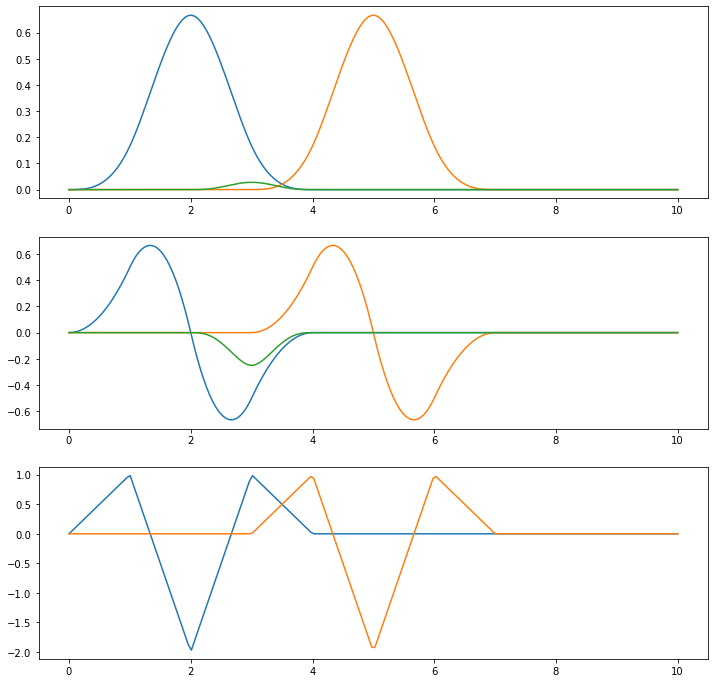

In [198]:
x, basis = BS.generate_basis_p()
x, grad_basis_1 = BS.generate_grad_basis_p(1)
x, grad_basis_2 = BS.generate_grad_basis_p(2)

# for i in range(len(knots)-p-1):
#     plt.plot(x, basis[:,i])

fig = plt.figure(figsize=(12,12))

ax1 = plt.subplot(311)
ax1.plot(x, basis[:,0])
ax1.plot(x, basis[:,3])
ax1.plot(xs, i2)

ax2 = plt.subplot(312)
ax2.plot(x, grad_basis_1[:,0])
ax2.plot(x, grad_basis_1[:,3])
ax2.plot(xs, i1)

ax3 = plt.subplot(313)
ax3.plot(x, grad_basis_2[:,0])
ax3.plot(x, grad_basis_2[:,3])
